## Importando as bibliotecas

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import OrdinalEncoder

import seaborn as sns
import matplotlib.pyplot as plt 

In [3]:
df_train = pd.read_csv('/home/ruan/codenation/enem-2/train.csv')
df_test = pd.read_csv('/home/ruan/codenation/enem-2/test.csv')

## Explorando os datasets:

In [4]:
print(df_train.describe())
print(len(df_train.columns)) # 167
print(len(df_test.columns))  # 47 

Unnamed: 0   NU_ANO  CO_MUNICIPIO_RESIDENCIA  CO_UF_RESIDENCIA  \
count  13730.000000  13730.0             1.373000e+04      13730.000000   
mean    2288.173926   2016.0             3.088548e+06         30.736708   
std     1321.230607      0.0             9.890495e+05          9.862405   
min        0.000000   2016.0             1.100023e+06         11.000000   
25%     1144.000000   2016.0             2.307650e+06         23.000000   
50%     2288.000000   2016.0             3.118601e+06         31.000000   
75%     3432.000000   2016.0             3.550308e+06         35.000000   
max     4586.000000   2016.0             5.300108e+06         53.000000   

           NU_IDADE  TP_ESTADO_CIVIL   TP_COR_RACA  TP_NACIONALIDADE  \
count  13730.000000     13202.000000  13730.000000      13730.000000   
mean      21.593809         0.116043      2.185652          1.048871   
std        7.043654         0.365986      1.007285          0.258895   
min       13.000000         0.000000      0.0

In [5]:
x=0
columns_test = list(df_test.columns)
for col in columns_test:
    if col in df_train:
        x=x+1
if x==47:
    print(" As mesmas colunas presentes df_test estão presentes em df_train\n")
else:
    print("Existem {} colunas diferentes\n",47-x)

As mesmas colunas presentes df_test estão presentes em df_train



 Já que as colunas presentes no df_test estão presentes no df_train, irei simplesmente dropar as colunas excedentes (Menos a coluna NU_NOTA_MT que é o Target da regressão)

In [6]:
for col in df_train.columns:
    if (not(col in df_test) and col != 'NU_NOTA_MT'):
        df_train.drop(col,axis=1,inplace=True)


### Checando o número de colunas, se tudo ok len(df_train.columns) == 48


In [7]:
print(len(df_train.columns) == 48) #True

True


Analisando os dados nulos presentes em ambos os datasets

In [8]:
df_nan = pd.DataFrame(columns=['dtypes','train_nan','train_nan(%)','test_nan','test_nan(%)','train nunique','test nunique'])
df_nan['dtypes'] = df_train.dtypes
df_nan['train_nan'] = df_train.isna().sum()
df_nan['train_nan(%)'] = df_train.isna().mean()
df_nan['test_nan'] = df_test.isna().sum()
df_nan['test_nan(%)'] = df_test.isna().mean()
df_nan['train nunique'] = df_train.nunique()
df_nan['test nunique'] = df_test.nunique()


In [9]:
print(df_nan.head(20))

dtypes  train_nan  train_nan(%)  test_nan  \
NU_INSCRICAO             object          0      0.000000       0.0   
CO_UF_RESIDENCIA          int64          0      0.000000       0.0   
SG_UF_RESIDENCIA         object          0      0.000000       0.0   
NU_IDADE                  int64          0      0.000000       0.0   
TP_SEXO                  object          0      0.000000       0.0   
TP_COR_RACA               int64          0      0.000000       0.0   
TP_NACIONALIDADE          int64          0      0.000000       0.0   
TP_ST_CONCLUSAO           int64          0      0.000000       0.0   
TP_ANO_CONCLUIU           int64          0      0.000000       0.0   
TP_ESCOLA                 int64          0      0.000000       0.0   
TP_ENSINO               float64       9448      0.688128    3096.0   
IN_TREINEIRO              int64          0      0.000000       0.0   
TP_DEPENDENCIA_ADM_ESC  float64       9448      0.688128    3096.0   
IN_BAIXA_VISAO            int64          0   

In [10]:
exists_nan = []
for ind in df_nan.index:
    try:
        if df_nan.loc[ind,'train_nan'] != 0:
            exists_nan.append(ind)
    except:
        pass


In [11]:
print(df_nan.loc[exists_nan,:])

dtypes  train_nan  train_nan(%)  test_nan  \
TP_ENSINO               float64       9448      0.688128    3096.0   
TP_DEPENDENCIA_ADM_ESC  float64       9448      0.688128    3096.0   
NU_NOTA_CN              float64       3389      0.246832    1134.0   
NU_NOTA_CH              float64       3389      0.246832    1134.0   
NU_NOTA_LC              float64       3597      0.261981    1199.0   
NU_NOTA_MT              float64       3597      0.261981       NaN   
TP_STATUS_REDACAO       float64       3597      0.261981    1199.0   
NU_NOTA_COMP1           float64       3597      0.261981    1199.0   
NU_NOTA_COMP2           float64       3597      0.261981    1199.0   
NU_NOTA_COMP3           float64       3597      0.261981    1199.0   
NU_NOTA_COMP4           float64       3597      0.261981    1199.0   
NU_NOTA_COMP5           float64       3597      0.261981    1199.0   
NU_NOTA_REDACAO         float64       3597      0.261981    1199.0   
Q027                     object       7373   

### Algumas colunas possuem uma porcentagem muito alta de dados nulos, por isso, irei prontamente excluí-las antes de prosseguir com a inputação de dados.

As colunas são:

TP_ENSINO                    9448      0.688128      3096     0.676573

TP_DEPENDENCIA_ADM_ESC       9448      0.688128      3096     0.676573  

Q027                         7373      0.536999      2488     0.543706 

É interessante observar também que a coluna IN_CEGUEIRA  possui apenas um valor tanto no teste quanto no treino, irei descartá-la também.   

Irei aglutinar as colunas que se referem a alguma deficiência em uma coluna só, chamada PCD e também irei concatenar o treino e o teste em um dataframe só, para facilitar as manipulações.

In [12]:
df_test['IN_PCD'] = np.int64(df_test.IN_BAIXA_VISAO | 
                             df_test.IN_CEGUEIRA | 
                             df_test.IN_SURDEZ |
                             df_test.IN_DISLEXIA |
                             df_test.IN_DISCALCULIA)

df_train['IN_PCD'] = np.int64(df_train.IN_BAIXA_VISAO | 
                             df_train.IN_CEGUEIRA | 
                             df_train.IN_SURDEZ |
                             df_train.IN_DISLEXIA |
                             df_train.IN_DISCALCULIA)
columns_test.append('IN_PCD')


In [13]:
target_col = 'NU_NOTA_MT'
# Garantindo a mesma ordem das colunas (Isso é importantíssimo)
df_train = df_train[columns_test + [target_col]]
df_test = df_test[columns_test]
data = pd.concat([df_train,df_test],keys=['train','test'])

In [14]:
data.head(50000)

NU_INSCRICAO  CO_UF_RESIDENCIA  \
train 0     ed50e8aaa58e7a806c337585efee9ca41f1eb1ad                43   
      1     2c3acac4b33ec2b195d77e7c04a2d75727fad723                23   
      2     f4545f8ccb9ff5c8aad7d32951b3f251a26e6568                23   
      3     3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe                33   
      4     bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268                13   
...                                              ...               ...   
test  4571  dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b                41   
      4572  a75fa8770257e7c9368d059fe53d9ef431f4bdef                35   
      4573  655fa6306720ff16e825903b5422a46608a77545                35   
      4574  1f4bc3e3d56212d500625bfe8ac78ccff4362293                52   
      4575  adf0d15b54317b6564ef56dad2b775bbb0ef50cc                33   

           SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_COR_RACA  TP_NACIONALIDADE  \
train 0                  RS        24       M            1                 1   
      1                  CE        17       F            3                 1   
      2                  CE        21       F            3                 1   
      3                  RJ        25       F            0                 1   
      4                  AM        28       M            2                 1   
...                     ...       ...     ...          ...               ...   
test  4571               PR        17       F            1                 1   
      4572               SP        17       M            2                 1   
      4573               SP        19       M            1                 1   
      4574               GO        17       M            2                 2   
      4575               RJ        30       M            1                 1   

            TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  ...  Q001  Q002  \
train 0                   1                4          1  ...     D     D   
      1                   2                0          2  ...     A     A   
      2                   3                0          1  ...     D     D   
      3                   1                9          1  ...     H     E   
      4                   1                4          1  ...     E     D   
...                     ...              ...        ...  ...   ...   ...   
test  4571                2                0          2  ...     E     E   
      4572                2                0          2  ...     C     C   
      4573                1                2          1  ...     D     F   
      4574                3                0          1  ...     C     E   
      4575                1               10          1  ...     C     C   

            Q006  Q024  Q025  Q026  Q027  Q047  IN_PCD  NU_NOTA_MT  
train 0        C     A     A     C     H     A       0       399.4  
      1        B     A     A     A   NaN     A       0       459.8  
      2        C     A     A     A   NaN     A       0         NaN  
      3        E     C     B     C     F     D       0         NaN  
      4        C     A     A     B     F     A       0         NaN  
...          ...   ...   ...   ...   ...   ...     ...         ...  
test  4571     D     A     B     A   NaN     A       0         NaN  
      4572     C     A     A     A   NaN     A       0         NaN  
      4573     D     B     B     A   NaN     D       0         NaN  
      4574     C     A     A     A   NaN     A       0         NaN  
      4575     A     B     B     B     B     A       0         NaN  

[18306 rows x 49 columns]

In [15]:
cols_to_drop = ['IN_BAIXA_VISAO',         # Incluso em PCD
                'IN_CEGUEIRA',            # Incluso em PCD
                'IN_SURDEZ',              # Incluso em PCD
                'IN_DISLEXIA',            # Incluso em PCD
                'IN_DISCALCULIA',         # Incluso em PCD
                'Q027',                   # Muitos dados nulos (53,69%)
                'TP_DEPENDENCIA_ADM_ESC', # Muitos dados nulos (68,81%)
                'TP_ENSINO' ,             # Muitos dados nulos (68,81%)
                'SG_UF_RESIDENCIA'        # Vai existir uma coluna codificada dela
]
data.drop(cols_to_drop,axis=1,inplace=True)
data.columns

Index(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'IN_TREINEIRO', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO',
       'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'CO_PROVA_CN',
       'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
       'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026',
       'Q047', 'IN_PCD', 'NU_NOTA_MT'],
      dtype='object')

### Agora que já dropamos as colunas que possuiam excesso de dados nulos, iremos tratar os dados nulos que ainda restaram

In [16]:
cols_to_fix = [
    'NU_NOTA_CH', 
    'NU_NOTA_CN',
    'NU_NOTA_LC',
    'NU_NOTA_MT',
    'NU_NOTA_COMP1', 
    'NU_NOTA_COMP2', 
    'NU_NOTA_COMP3', 
    'NU_NOTA_COMP4', 
    'NU_NOTA_COMP5',
    'NU_NOTA_REDACAO'
]

for col in cols_to_fix:
    data[col] = data[col].fillna(0.)

Conferindo :

In [17]:
data.isna().mean()

NU_INSCRICAO         0.000000
CO_UF_RESIDENCIA     0.000000
NU_IDADE             0.000000
TP_SEXO              0.000000
TP_COR_RACA          0.000000
TP_NACIONALIDADE     0.000000
TP_ST_CONCLUSAO      0.000000
TP_ANO_CONCLUIU      0.000000
TP_ESCOLA            0.000000
IN_TREINEIRO         0.000000
IN_SABATISTA         0.000000
IN_GESTANTE          0.000000
IN_IDOSO             0.000000
TP_PRESENCA_CN       0.000000
TP_PRESENCA_CH       0.000000
TP_PRESENCA_LC       0.000000
CO_PROVA_CN          0.000000
CO_PROVA_CH          0.000000
CO_PROVA_LC          0.000000
CO_PROVA_MT          0.000000
NU_NOTA_CN           0.000000
NU_NOTA_CH           0.000000
NU_NOTA_LC           0.000000
TP_LINGUA            0.000000
TP_STATUS_REDACAO    0.261991
NU_NOTA_COMP1        0.000000
NU_NOTA_COMP2        0.000000
NU_NOTA_COMP3        0.000000
NU_NOTA_COMP4        0.000000
NU_NOTA_COMP5        0.000000
NU_NOTA_REDACAO      0.000000
Q001                 0.000000
Q002                 0.000000
Q006      

A coluna NU_NOTA_REDACAO precisa ser tratada independentemente, iremos subsittuir o valor dos dados nulos por 2, que no dicionário de dados significa "anulada".

In [18]:
cols_to_fix = [
    'TP_STATUS_REDACAO'
]

for col in cols_to_fix:
    data[col] = data[col].fillna(2.)

Conferindo :

In [19]:
if data.loc[:,'NU_NOTA_REDACAO'].isna().mean() == 0 :
    print("Ok, sem dados nulos na coluna NU_NOTA_REDACAO\n")

Ok, sem dados nulos na coluna NU_NOTA_REDACAO



## Codificando features do tipo object:

In [20]:
cols_to_encode = [
    'CO_PROVA_CH',
    'CO_PROVA_CN',
    'CO_PROVA_LC',
    'CO_PROVA_MT',
    'Q001',
    'Q002',
    'Q006',
    'Q024',
    'Q025',
    'Q026',
    'Q047',
    'TP_SEXO'
]
for col in cols_to_encode:
    print(f'Codificando feature {col}')
    
    encoder = OrdinalEncoder()
    encoder.fit(data[col].to_frame())
    
    data[col] = encoder.transform(data[col].to_frame())

Codificando feature CO_PROVA_CH
Codificando feature CO_PROVA_CN
Codificando feature CO_PROVA_LC
Codificando feature CO_PROVA_MT
Codificando feature Q001
Codificando feature Q002
Codificando feature Q006
Codificando feature Q024
Codificando feature Q025
Codificando feature Q026
Codificando feature Q047
Codificando feature TP_SEXO


## Feature Engineering:

<AxesSubplot:xlabel='NU_IDADE', ylabel='count'>

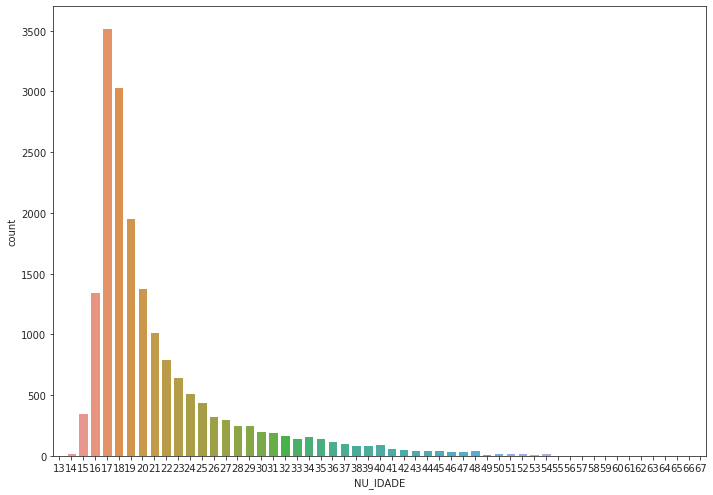

In [21]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.countplot(x='NU_IDADE', data=data)

Já que há um **aglomerado** interessante de pessoas em um intervalo curto de idades, podemos separar as idades em bins para melhor _alimentar o modelo_ , poderemos então dropar as colunas NU_IDADE e IN_IDOSO

In [22]:
data['TP_IDADE_AGRUPADA'] = pd.cut(data['NU_IDADE'], bins=[0, 17, 19, 21, 26, 31, 41, 100], labels=range(7)).ravel()
# as colunas de idade e indicando se é idoso não fazem mais sentido
data.drop(columns=['NU_IDADE', 'IN_IDOSO'], inplace=True)

In [24]:
data['TP_IDADE_AGRUPADA']

train  0       3
       1       0
       2       2
       3       3
       4       4
              ..
test   4571    0
       4572    0
       4573    1
       4574    0
       4575    4
Name: TP_IDADE_AGRUPADA, Length: 18306, dtype: category
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]

Feature para identificar se o candidato é estrangeiro ou não.

In [25]:
data['IN_ESTRANGEIRO'] = np.int64(~data['TP_NACIONALIDADE'].isin([0, 1, 2, 4]))
data.drop(columns=['TP_NACIONALIDADE'], inplace=True)